In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches
import seaborn as sns
from sklearn import preprocessing
import numpy as np
import math
import pickle

path = './mesoscale_comparison/'

import neuro_morpho_toolbox as nmt

/Users/pengxie/Documents/Research/python/neuro_morhpo_toolbox/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.56
Loading CCF brain structure data...
Loading time: 0.01
Loading flat_map ...
Loading time: 2.57


## Mesoscale list

In [2]:
SSp_list = ['SSp-bfd', 'SSp-m', 'SSp-n', 'SSp-ll', 'SSp-ul', 'SSp-tr', 'SSp-un']

In [3]:
meta_meso = pd.read_excel('/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/Hongkui/single cell_meso groups_source match_thresholded meso_2021-03_PX.xlsx',
                          index_col=[0], sheet_name='meso fraction total PV_thre HZ'
                         )
tp = []
for i in meta_meso['reassigned primary-layer'].tolist():
    if i.endswith('-'):
        tp.append('-'.join(i.split('-')[:-1]))
    else:
        tp.append(i)
meta_meso['reassigned primary-layer'] = tp

# Re-group 
tp = [i+'-L2/3' for i in SSp_list]
meta_meso.loc[meta_meso['reassigned primary-layer'].isin(tp), 'reassigned primary-layer'] = 'SSp-L2/3_IT'
tp = [i+'-L4' for i in SSp_list]
meta_meso.loc[meta_meso['reassigned primary-layer'].isin(tp), 'reassigned primary-layer'] = 'SSp-L4_IT'
tp = [i+'-L5_IT' for i in SSp_list]
meta_meso.loc[meta_meso['reassigned primary-layer'].isin(tp), 'reassigned primary-layer'] = 'SSp-L5_IT'
tp = [i+'-L5_PT' for i in SSp_list]
meta_meso.loc[meta_meso['reassigned primary-layer'].isin(tp), 'reassigned primary-layer'] = 'SSp-L5_ET'
tp = ['SSs-L5_PT']
meta_meso.loc[meta_meso['reassigned primary-layer'].isin(tp), 'reassigned primary-layer'] = 'SSs-L5_ET'
tp = ['MOs-L4', 'MOp-L4']
meta_meso.loc[meta_meso['reassigned primary-layer'].isin(tp), 'reassigned primary-layer'] = 'MO-L4_IT'
tp = ['MOs-L5_IT', 'MOp-L5_IT']
meta_meso.loc[meta_meso['reassigned primary-layer'].isin(tp), 'reassigned primary-layer'] = 'MO-L5_IT'
tp = ['MOs-L5_PT', 'MOp-L5_PT']
meta_meso.loc[meta_meso['reassigned primary-layer'].isin(tp), 'reassigned primary-layer'] = 'MO-L5_ET'
meta_meso.loc[meta_meso['reassigned primary-layer']=='MOp-L2/3', 'reassigned primary-layer'] = 'MOp-L2/3_IT'
meta_meso.loc[meta_meso['reassigned primary-layer']=='MOs-L2/3', 'reassigned primary-layer'] = 'MOs-L2/3_IT'
meta_meso.loc[meta_meso['reassigned primary-layer']=='SSs-L2/3', 'reassigned primary-layer'] = 'SSs-L2/3_IT'
group_list = meta_meso['reassigned primary-layer'].unique().tolist()
sorted(group_list)

['AM',
 'CLA',
 'CM',
 'CP',
 'IAD',
 'LD',
 'LGd',
 'LP',
 'MD',
 'MG',
 'MO-L4_IT',
 'MO-L5_ET',
 'MO-L5_IT',
 'MOp-L2/3_IT',
 'MOs-L2/3_IT',
 'PO',
 'PVT',
 'RE',
 'SSp-L2/3_IT',
 'SSp-L4_IT',
 'SSp-L5_ET',
 'SSp-L5_IT',
 'SSs-L2/3_IT',
 'SSs-L5_ET',
 'SSs-L5_IT',
 'SSs-L6b',
 'VAL',
 'VM',
 'VPL',
 'VPM']

In [4]:
meta_meso['reassigned primary-layer'].value_counts()

MO-L5_ET       27
CP             20
SSp-L5_ET      17
MO-L5_IT        9
MOs-L2/3_IT     8
SSp-L2/3_IT     8
SSp-L4_IT       7
SSp-L5_IT       7
MD              6
LGd             6
LD              4
SSs-L5_ET       4
MG              3
AM              3
PO              3
PVT             3
LP              3
VPM             3
SSs-L2/3_IT     3
SSs-L6b         2
MOp-L2/3_IT     2
SSs-L5_IT       2
VAL             2
MO-L4_IT        2
VM              2
CLA             2
RE              2
VPL             1
CM              1
IAD             1
Name: reassigned primary-layer, dtype: int64

## Single cell list

In [5]:
rough_list = ['CTX', 'CNU', 'TH', 'HB', 'HPF', 'HY']
region_to_rough = {'unknown':'unknown'}
for i in rough_list:
    for j in nmt.bs.get_all_child_id(i):
        region_to_rough[nmt.bs.id_to_name(j)] = i


In [6]:
[ns] = pickle.load(open('./neuron_set_1741cells.pickle', 'rb'))
metadata = ns.metadata.copy()
metadata.fillna('', inplace=True)
metadata['CreLine'] = [i.split('-')[0] for i in metadata['Transgenic_line'].tolist()]

metadata.rename(columns={'Manually_corrected_soma_region':'CellType',
                         'Cortical_layer':'Layer'
                        }, inplace=True)
metadata['CellType'] = metadata['CellType'].str.strip()

metadata['CellType_Rough'] = metadata['CellType'].map(region_to_rough)

In [7]:
PT_list = metadata[metadata['Subclass_or_type']=='CTX_ET'].index.tolist()
print('# PT cells:\t%d' % (len(PT_list)))


# PT cells:	238


In [8]:
IT_list = metadata[metadata['Subclass_or_type']=='CTX_IT'].index.tolist()
print('# IT cells:\t%d' % (len(IT_list)))


# IT cells:	217


In [9]:
meta_single = metadata.copy()
full_type = []
for i in meta_single.index.tolist():
    tp = meta_single.loc[i].copy()
    if tp['CellType_Rough']=='CTX':
        if tp['CellType']=='CLA':
            tp = 'CLA'
        else:
            tp = tp['CellType']+'-L'+str(tp['Layer'])
            if i in PT_list:
                tp = tp
                if tp.endswith('L5'):
                    tp = tp+'_PT'
            if i in IT_list:
                tp = tp
                if tp.endswith('L5'):
                    tp = tp+'_IT'
    else:
        tp = tp['CellType']
    full_type.append(tp)
meta_single['reassigned primary-layer'] = full_type

In [10]:
# Re-group 
tp = [i+'-L2/3' for i in SSp_list]
meta_single.loc[meta_single['reassigned primary-layer'].isin(tp), 'reassigned primary-layer'] = 'SSp-L2/3_IT'
tp = [i+'-L4' for i in SSp_list]
meta_single.loc[meta_single['reassigned primary-layer'].isin(tp), 'reassigned primary-layer'] = 'SSp-L4_IT'
tp = [i+'-L5_IT' for i in SSp_list]
meta_single.loc[meta_single['reassigned primary-layer'].isin(tp), 'reassigned primary-layer'] = 'SSp-L5_IT'
tp = [i+'-L5_PT' for i in SSp_list]
meta_single.loc[meta_single['reassigned primary-layer'].isin(tp), 'reassigned primary-layer'] = 'SSp-L5_ET'

meta_single.loc[meta_single['reassigned primary-layer']=='SSs-L2/3', 'reassigned primary-layer'] = 'SSs-L2/3_IT'
tp = ['SSs-L5_PT']
meta_single.loc[meta_single['reassigned primary-layer'].isin(tp), 'reassigned primary-layer'] = 'SSs-L5_ET'
tp = ['SSs-L6', 'SSs-L6b']
meta_single.loc[((meta_single['reassigned primary-layer'].isin(tp)) & (meta_single['Subclass_or_type']=='Car3')), 
                'reassigned primary-layer'] = 'SSs-L6b'

meta_single.loc[meta_single['reassigned primary-layer']=='MOp-L2/3', 'reassigned primary-layer'] = 'MOp-L2/3_IT'
meta_single.loc[meta_single['reassigned primary-layer']=='MOs-L2/3', 'reassigned primary-layer'] = 'MOs-L2/3_IT'
tp = ['MOs-L4', 'MOp-L4']
meta_single.loc[meta_single['reassigned primary-layer'].isin(tp), 'reassigned primary-layer'] = 'MO-L4_IT'
tp = ['MOs-L5_IT', 'MOp-L5_IT']
meta_single.loc[meta_single['reassigned primary-layer'].isin(tp), 'reassigned primary-layer'] = 'MO-L5_IT'
tp = ['MOs-L5_PT', 'MOp-L5_PT']
meta_single.loc[meta_single['reassigned primary-layer'].isin(tp), 'reassigned primary-layer'] = 'MO-L5_ET'



In [11]:
meta_single = meta_single[meta_single['reassigned primary-layer'].isin(group_list)]
tp = meta_single['reassigned primary-layer'].value_counts()
tp = tp[tp>=3].index.tolist()

# Groups excluded as not having enough single cells
[i for i in group_list if not i in tp]

['IAD']

In [12]:
group_list = [i for i in group_list if i in tp]

## Read paring table

In [13]:
matches_single = meta_single.copy()[['reassigned primary-layer']]
matches_single['experiment-type'] = 'single cell'

matches_meso = meta_meso.copy()[['reassigned primary-layer']]
matches_meso['experiment-type'] = 'mesoscale'

In [14]:
matches = pd.concat([matches_meso, matches_single], axis=0)

In [15]:
matches.head()


,reassigned primary-layer,experiment-type
266174045,AM,mesoscale
573035760,AM,mesoscale
514333422,AM,mesoscale
514505957,CLA,mesoscale
485902743,CLA,mesoscale


## Read mesoscale data

In [16]:
# mesoscale_projection_volumes =pd.read_excel(path+'single cell_meso groups_source match_thresholded meso_hz.xlsx', 
#                                           index_col=[0], sheet_name='meso fraction HZ_selected', skiprows=range(5))
mesoscale_projection_volumes = pd.read_excel('/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/Hongkui/single cell_meso groups_source match_thresholded meso_2021-03_PX.xlsx',
                          index_col=[0], sheet_name='meso fraction total PV_thre HZ'
                         ) 
mesoscale_projection_volumes = mesoscale_projection_volumes.iloc[:,7:]
mesoscale_projection_volumes.head()

,FRP-ipsi,MOp-ipsi,MOs-ipsi,SSp-n-ipsi,SSp-bfd-ipsi,SSp-ll-ipsi,SSp-m-ipsi,SSp-ul-ipsi,SSp-tr-ipsi,SSp-un-ipsi,...,SIM-contra,AN-contra,PRM-contra,COPY-contra,PFL-contra,FL-contra,FN-contra,IP-contra,DN-contra,VeCB-contra
image-series-id,,,,,,,,,,,,,,,,,,,,,
266174045,0.000000,0.000000,0.004232,0.000000,0.000000,0.000288,0.000000,0.000000,0.000408,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573035760,0.000727,0.000346,0.027247,0.000000,0.000000,0.000196,0.000000,0.000033,0.000393,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
514333422,0.000000,0.000285,0.043908,0.000000,0.000000,0.000097,0.000000,0.000000,0.000069,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
514505957,0.033190,0.020123,0.141569,0.000000,0.000000,0.000000,0.001456,0.000140,0.001226,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
485902743,0.014744,0.085331,0.178729,0.000665,0.007516,0.022248,0.004147,0.018157,0.006153,0.004062,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
## SSp-L4_IT neurons are retrograde labeling of AAV tracer from SSp to VPM, set VPM to 0
tp = matches[((matches['reassigned primary-layer']=='SSp-L4_IT') & (matches['experiment-type']=='mesoscale'))].index.tolist()
mesoscale_projection_volumes.loc[tp, ['VPM-ipsi', 'VPM-contra']] = 0

## Read single cell data

In [18]:
singlecell_axon_matrix = ns.features['projection_features'].raw_data.copy()/1000
singlecell_axon_matrix.drop(columns=['ipsi_fiber tracts', 'contra_fiber tracts'], inplace=True)
old_col = singlecell_axon_matrix.columns.tolist()
new_col = []
for i in old_col:
    if 'ipsi' in i:
        i = i.replace('ipsi_', '')+'-ipsi'
    else:
        i = i.replace('contra_', '')+'-contra'
    new_col.append(i)
singlecell_axon_matrix.rename(columns=dict(zip(old_col, new_col)), inplace=True)
singlecell_axon_matrix = singlecell_axon_matrix[mesoscale_projection_volumes.columns]
singlecell_axon_matrix.head()

,FRP-ipsi,MOp-ipsi,MOs-ipsi,SSp-n-ipsi,SSp-bfd-ipsi,SSp-ll-ipsi,SSp-m-ipsi,SSp-ul-ipsi,SSp-tr-ipsi,SSp-un-ipsi,...,SIM-contra,AN-contra,PRM-contra,COPY-contra,PFL-contra,FL-contra,FN-contra,IP-contra,DN-contra,VeCB-contra
17109_1701_x8048_y22277,3.102773,1.141034,13.621949,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17109_1801_x6698_y12550,4.051807,1.404260,31.022748,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17109_1901_x9602_y10508,2.622707,0.000000,1.050619,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17109_2201_x8046_y23301,1.069626,24.759327,17.766879,0.0,0.0,0.0,8.188973,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17109_2301_x8535_y23051,0.059462,8.733278,12.673723,0.0,0.0,0.0,0.080316,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Diagram

In [165]:
thres_single = 1
thres_single_log = 0
thres_single_percent = 0.1
thres_meso_log = 0.2
thres_meso_percent = 0.5

region_all = mesoscale_projection_volumes.columns.tolist()
region_all = [i.replace('-ipsi', '') for i in region_all if i.endswith('-ipsi')]

# def get_region_list(group_name):
#     cmatches = matches[matches['reassigned primary-layer']==group_name].copy()
#     mlist = cmatches[cmatches['experiment-type']=='mesoscale']['image-series-id'].tolist()
    
#     # Select regions
#     mdf = mesoscale_projection_volumes.loc[mlist].copy()
#     region_list = (mdf>0).all(axis=0)
#     region_list = region_list[region_list].index.tolist()
#     region_list = list(set([i.replace('-ipsi', '').replace('-contra', '') for i in region_list]))
#     region_list = [i for i in region_all if (i in region_list)]    
#     return region_list
CB_list = [nmt.bs.id_to_name(i) for i in nmt.bs.get_all_child_id('CB')]
def get_region_list(group_name):
    cmatches = matches[matches['reassigned primary-layer']==group_name].copy()
    mlist = cmatches[cmatches['experiment-type']=='mesoscale'].index.tolist()
    slist = cmatches[cmatches['experiment-type']=='single cell'].index.tolist()
    
    mdf = mesoscale_projection_volumes.loc[mlist].copy()
    mdf = np.log(mdf*100+1)
    mlist = mdf.index.tolist()
    sdf = singlecell_axon_matrix.loc[slist].copy()
    sdf[sdf<thres_single] = thres_single
#     sdf = sdf / np.array(sdf.sum(axis=1)).reshape(-1,1)    
    sdf = np.log(sdf+thres_single-1)
    sdf = sdf.sort_index()
    slist = sdf.index.tolist()   
    
    # 1. select regions
    cregions1 = (mdf>thres_meso_log).sum(axis=0)>=max(1, len(mlist)*thres_meso_percent)
#     cregions1 = (mdf>thres_meso_log).any(axis=0)
    cregions1 = cregions1[cregions1].index.tolist()
    cregions2 = (sdf>thres_single_log).sum(axis=0)>=max(2, len(slist)*thres_single_percent)
#     cregions2 = (sdf>thres_single_log).any(axis=0)
    cregions2 = cregions2[cregions2]
    cregions2 = cregions2[~cregions2.index.isin(cregions1)].index.tolist()
    cregions = cregions1 + cregions2
 
    # remove cerebellum
    region_list = []
    cregions_res = []
    for i in cregions:
        tp = i.replace('-ipsi', '').replace('-contra', '')
        if tp in CB_list:
            continue
        cregions_res.append(i)
        region_list.append(tp)
    region_list = [i for i in region_all if (i in region_list)]    

    return region_list, cregions

def get_group_df(group_name, region_list=None):
    cmatches = matches[matches['reassigned primary-layer']==group_name].copy()
    slist = cmatches[cmatches['experiment-type']=='single cell'].index.tolist()
    mlist = cmatches[cmatches['experiment-type']=='mesoscale'].index.tolist()
    
    if region_list is None:
        region_list, cregions = get_region_list(group_name)
    
    # Get dataframe
    mdf = mesoscale_projection_volumes.loc[mlist].copy()
    mdf = np.log(mdf*100+1)
    mdf = (mdf>thres_meso_log).mean(axis=0)
    sdf = singlecell_axon_matrix.loc[slist].copy()
    sdf = (sdf>thres_single).mean(axis=0)
    
    r1 = [i+'-ipsi' for i in region_list]
    r2 = [i+'-contra' for i in region_list]
    
    sdf = pd.DataFrame({'ipsi':sdf.loc[r1].tolist(),
                        'contra':sdf.loc[r2].tolist()
                       }, index=region_list)
    mdf = pd.DataFrame({'ipsi':mdf.loc[r1].tolist(),
                        'contra':mdf.loc[r2].tolist()
                       }, index=region_list)
    
    return sdf, mdf
   
get_group_df('MOp-L2/3_IT')    
        

(         ipsi  contra
 MOp      0.90    0.30
 MOs      0.90    0.45
 SSp-bfd  0.05    0.00
 SSp-ll   0.35    0.00
 SSp-m    0.30    0.00
 SSp-ul   0.30    0.05
 SSp-tr   0.15    0.00
 SSp-un   0.05    0.00
 SSs      0.15    0.00
 AUDd     0.00    0.00
 AUDv     0.00    0.00
 ACAd     0.25    0.00
 PL       0.05    0.05
 ORBl     0.00    0.00
 ORBvl    0.00    0.00
 RSPagl   0.15    0.00
 RSPd     0.30    0.00
 RSPv     0.05    0.05
 VISa     0.05    0.00
 VISrl    0.05    0.00
 ENTl     0.05    0.00
 CP       0.45    0.05
 PO       0.00    0.00,
          ipsi  contra
 MOp       1.0     1.0
 MOs       1.0     1.0
 SSp-bfd   1.0     0.0
 SSp-ll    1.0     0.5
 SSp-m     0.0     0.0
 SSp-ul    1.0     0.0
 SSp-tr    1.0     0.5
 SSp-un    0.5     0.0
 SSs       0.5     0.5
 AUDd      0.5     0.0
 AUDv      0.5     0.0
 ACAd      1.0     0.0
 PL        0.5     0.0
 ORBl      0.5     0.0
 ORBvl     0.5     0.0
 RSPagl    1.0     1.0
 RSPd      0.5     0.5
 RSPv      0.5     0.0
 VISa     

In [166]:
group_meta = pd.DataFrame(index=group_list)
tp = []
for i in group_list:
    if i.find('-')<0:
        tp.append(i)
    else:
        tp.append('-'.join(i.split('-')[:-1]))
    
group_meta['Region'] = tp

# Group as large structures
structure_list = ['CTX', 'TH', 'STR', 'MY', 'P', 'MB', 'HY']
structure_dict = {}
structure_palette = sns.palettes.color_palette('tab10')
structure_cmap = dict(zip(structure_list+['others'],
                          structure_palette[:len(structure_list)+1]))

for cs in structure_list:
    tp = [nmt.bs.id_to_name(i) for i in nmt.bs.get_all_child_id(cs) if i in nmt.bs.selected_regions]
    tp = dict(zip(tp, [cs]*len(tp)))
    structure_dict.update(tp)
structure_dict['MO'] = 'CTX'
structure_dict['SSp'] = 'CTX'
group_meta['Structure'] = [structure_dict[i] for i in group_meta['Region'].tolist()]


In [167]:
def alpha_to_color(alpha, color=[0.5,0,0], min_alpha=0.1):
    if type(alpha) != list:
        alpha = alpha.tolist()
    res = []
    for i in alpha:
        cc = color
        cc = cc + [max(min_alpha, i)]      
        res.append(tuple(cc))
    return res

# regions:	50
# Single cells:	364
# Meso exp:	55


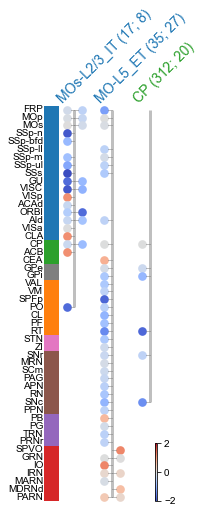

In [168]:
def plot_diagram(group_list, region_list, ax=None, savefig=None, vmin=-2, vmax=2):

    n_region = len(region_list)
    n_group = len(group_list)
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(0.8*n_group, 0.16*n_region))      
        
    ys = np.linspace(n_region-1,0,num=n_region)
    # Add text for rows
    for i,cregion in enumerate(region_list):        
        # Add the patch to the Axes
        if cregion in structure_dict.keys():
            row_col = structure_dict[cregion]
            row_col = structure_cmap[row_col]
        else:
            row_col = structure_cmap['others']
        
        rect = patches.Rectangle((-3, ys[i]-0.5),2,1,
                                 linewidth=0, 
                                 edgecolor='none',facecolor=row_col)
        ax.add_patch(rect)        
        ax.text(-3.1, ys[i], cregion, fontdict={'ha':'right', 'va':'center'})
        
    n_meso = 0
    n_single = 0
    
    for i,cgroup in enumerate(group_list):
        step = 5
        x1 = [step*i]*n_region
        x2 = step*i+1
        x3 = [step*i+2]*n_region
        
        # Setup colors
        if group_meta.loc[cgroup, 'Region'] in structure_dict:
            color = structure_dict[group_meta.loc[cgroup, 'Region']]
            color = structure_cmap[color]
        else:
            color = structure_cmap['others']
            
        cmatches = matches[matches['reassigned primary-layer']==cgroup].copy()
        slist = cmatches[cmatches['experiment-type']=='single cell'].index.tolist()
        mlist = cmatches[cmatches['experiment-type']=='mesoscale'].index.tolist()
        
        n_meso = n_meso + len(mlist)
        n_single = n_single + len(slist)

        cregion_list, cregions = get_region_list(cgroup)
        sdf, mdf = get_group_df(cgroup, region_list=region_list)
        sdf = np.log10(sdf*100+1)
        mdf = np.log10(mdf*100+1)
        col_ipsi = sdf['ipsi'] - mdf['ipsi']
        col_contra = sdf['contra'] - mdf['contra']
            
        # Horizontal connections & Dot plots
        for j,cregion in enumerate(region_list):
            if (cregion+'-ipsi' in cregions):                
                ax.plot([x1[0]+0.5, x2], [ys[j]]*2, linewidth=1, c='grey', alpha=0.5)                 
                axs = ax.scatter(x1[j], ys[j], c=[col_ipsi[j]], s=75, linewidths=0, vmin=vmin, vmax=vmax, cmap='coolwarm')
            if (cregion+'-contra' in cregions):                
                ax.plot([x2, x3[0]-0.5], [ys[j]]*2, linewidth=1, c='grey', alpha=0.5)                 
                axs = ax.scatter(x3[j], ys[j], c=[col_contra[j]], s=75, linewidths=0, vmin=vmin, vmax=vmax, cmap='coolwarm')      

        # Vertical connection
        tp = mdf.copy() + sdf.copy()
        tp['y'] = ys
        tp['targeted'] = [((i+'-ipsi' in cregions) | (i+'-contra' in cregions)) for i in tp.index.tolist()]
        tp = tp[tp['targeted']]['y'].min()
        ax.vlines(x2, n_region-1, tp, linewidth=3, color='grey', alpha=0.5)
        cgroup_text = cgroup
        if cgroup_text.endswith('-'):
            cgroup_text = '-'.join(cgroup_text.split('-')[:-1])
        cgroup_text = cgroup_text.replace('_PT', '_ET')
        cgroup_text = '%s (%d; %d)' % (cgroup_text, len(slist), len(mlist))
        ax.text(x2-0.5*step, n_region-0.5, cgroup_text, fontdict={'ha':'left', 'va':'bottom', 
                                                         'rotation':45, 'color':color,
                                                         'fontsize':14
                                                        })
#     ax.invert_yaxis()
    ax.axis('off')
    extend = ax.get_xlim()[1]*0.1
    ax.set_xlim((ax.get_xlim()[0]-extend, 
                 ax.get_xlim()[1]+extend
                ))
#     fig.colorbar(axs, ax=ax, panchor=(0,0.05), shrink=0.5, pad=0.04)
    # Now adding the colorbar
    cbaxes = fig.add_axes([0.85, 0.16, 0.01, 0.1]) 
#     cb = plt.colorbar(ax1, cax = cbaxes)  
    fig.colorbar(axs, cax=cbaxes)
    if savefig is not None:
        fig.savefig(savefig, bbox_inches='tight')
    print('# Single cells:\t%d' % (n_single))
    print('# Meso exp:\t%d' % (n_meso))
    return sdf, mdf

cgroup_list = ['MOs-L2/3_IT', 'MO-L5_ET', 'CP']

# Get region_list:
region_selected = []

for cgroup in cgroup_list:
    tp, _ = get_region_list(cgroup)
    region_selected = region_selected + tp
    
region_selected = [i for i in region_all if i in region_selected]
print("# regions:\t%d" % (len(region_selected)))

sdf, mdf = plot_diagram(cgroup_list, region_selected, ax=None, savefig='../Figure/single_vs_mesoscale_diagram_test.pdf')


## Cortical regions

In [169]:
cgroup_list = [
 'MOp-L2/3_IT',
 'MOs-L2/3_IT',
 'MO-L4_IT',
 'MO-L5_IT',
 'MO-L5_ET',
 'SSp-L2/3_IT',
 'SSp-L4_IT',
 'SSp-L5_IT',
 'SSp-L5_ET',
 'SSs-L2/3_IT',
 'SSs-L5_IT', 
 'SSs-L5_ET', 
    'SSs-L6b',
    'CLA',
 'VPL',
 'VPM',
 'LGd',
 'MG',
 'VAL',
 'PO',
 'VM',
    'LP',
 'AM',
 'LD',
 'RE',
 'CM',
    'MD',

              'CP']

# regions:	159
# Single cells:	1354
# Meso exp:	159


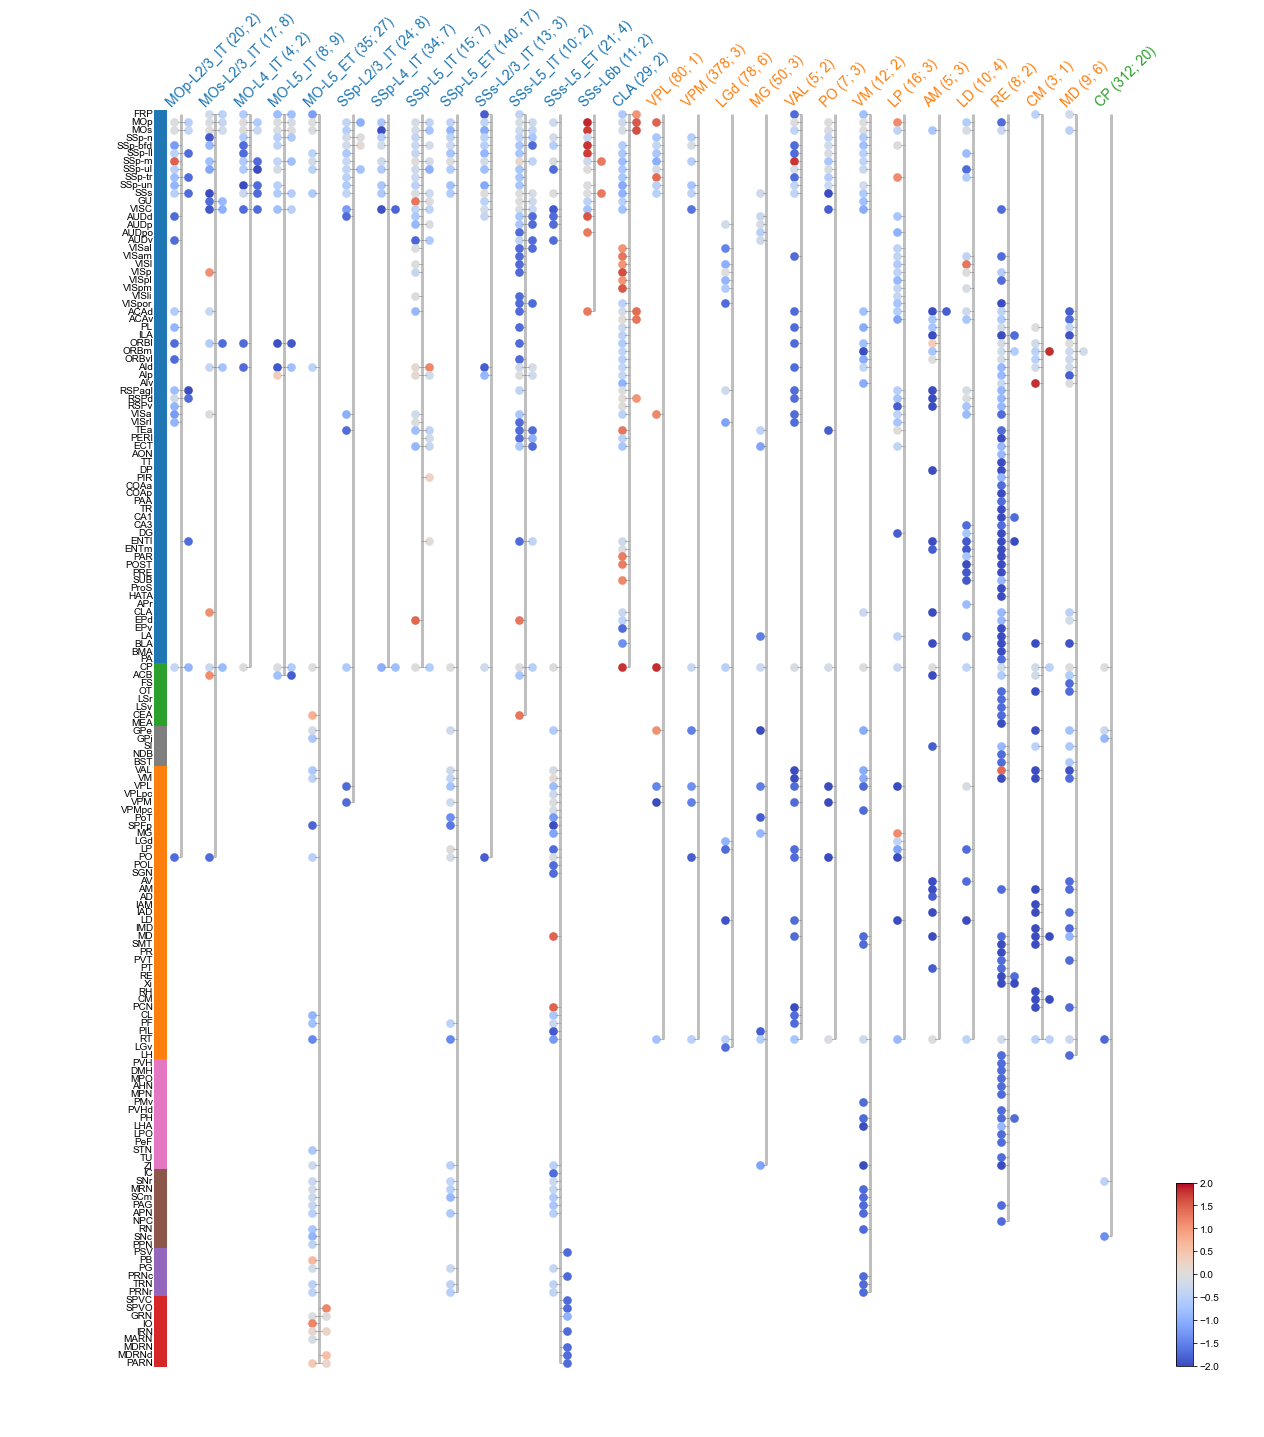

In [170]:
# Get region_list:
region_selected = []

for cgroup in cgroup_list:
    tp, _ = get_region_list(cgroup)
    region_selected = region_selected + tp
    
region_selected = [i for i in region_all if i in region_selected]
if 'PFL' in region_selected:
    region_selected.remove('PFL')
if 'AN' in region_selected:
    region_selected.remove('AN')
print("# regions:\t%d" % (len(region_selected)))

sdf, mdf = plot_diagram(cgroup_list, region_selected, ax=None, savefig='../Figure/single_vs_mesoscale_diagram_v2.pdf')


In [171]:
tlist = meta_meso[meta_meso['reassigned primary-layer']=='SSp-L5_IT'].index.tolist()

In [172]:
mesoscale_projection_volumes.loc[tlist, 'PO-ipsi']

image-series-id
288170549    0.0
297654263    0.0
296052839    0.0
591622344    0.0
303614706    0.0
298182842    0.0
303615412    0.0
Name: PO-ipsi, dtype: float64

In [173]:
meta_meso.loc[tlist]

,mouse-strain,dataset-name,graph-order,primary-injection-structure,secondary-injection-structures,reassigned primary-layer,Sum PV (excl fiber tracts),FRP-ipsi,MOp-ipsi,MOs-ipsi,...,SIM-contra,AN-contra,PRM-contra,COPY-contra,PFL-contra,FL-contra,FN-contra,IP-contra,DN-contra,VeCB-contra
image-series-id,,,,,,,,,,,,,,,,,,,,,
288170549,Tlx3-Cre_PL56,mca_classic,51,SSp-bfd,SSp-n|SSp-un,SSp-L5_IT,1.163621,0.003299,0.111217,0.154592,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000021,0.000000,0.000000,0.0
297654263,Tlx3-Cre_PL56,mca_classic,51,SSp-bfd,NaN,SSp-L5_IT,2.743123,0.000462,0.040492,0.079785,...,0.000357,0.004589,0.001226,0.000392,0.0,0.000772,0.000006,0.000008,0.000027,0.0
296052839,Tlx3-Cre_PL56,mca_classic,65,SSp-ll,SSp-ul,SSp-L5_IT,1.165148,0.000241,0.128219,0.029846,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000022,0.000000,0.000000,0.0
591622344,Tlx3-Cre_PL56,mca_classic,65,SSp-ll,MOp,SSp-L5_IT,1.348652,0.000000,0.108423,0.021466,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
303614706,Tlx3-Cre_PL56,mca_classic,72,SSp-m,SSp-n|SSp-ul|SSp-un,SSp-L5_IT,2.792967,0.010648,0.158953,0.097806,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
298182842,Tlx3-Cre_PL56,mca_classic,86,SSp-tr,SSp-ll|VISa,SSp-L5_IT,0.906285,0.000000,0.030743,0.006656,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
303615412,Tlx3-Cre_PL56,mca_classic,79,SSp-ul,MOp,SSp-L5_IT,1.207266,0.003389,0.166891,0.093956,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0


## Beta value

In [32]:
def my_ssp_combine(tdf):
    face_list_ipsi = [i for i in ['SSp-bfd-ipsi', 'SSp-m-ipsi', 'SSp-n-ipsi'] if i in tdf.columns.tolist()]
    if len(face_list_ipsi)>0:
        tdf['SSp-f-ipsi'] = tdf[face_list_ipsi].sum(axis=1) # combine as SSp-face
        tdf.drop(columns=face_list_ipsi, inplace=True)
    face_list_contra = [i for i in ['SSp-bfd-contra', 'SSp-m-contra', 'SSp-n-contra'] if i in tdf.columns.tolist()]
    if len(face_list_contra)>0:
        tdf['SSp-f-contra'] = tdf[face_list_contra].sum(axis=1) # combine as SSp-face
        tdf.drop(columns=face_list_contra, inplace=True)
    
    tl_list_ipsi = [i for i in ['SSp-tr-ipsi', 'SSp-ul-ipsi', 'SSp-ll-ipsi'] if i in tdf.columns.tolist()]
    if len(tl_list_ipsi)>0:
        tdf['SSp-tl-ipsi'] = tdf[tl_list_ipsi].sum(axis=1) # combine as SSp-trunk-limb
        tdf.drop(columns=tl_list_ipsi, inplace=True)
    tl_list_contra = [i for i in ['SSp-tr-contra', 'SSp-ul-contra', 'SSp-ll-contra'] if i in tdf.columns.tolist()]
    if len(tl_list_contra)>0:
        tdf['SSp-tl-contra'] = tdf[tl_list_contra].sum(axis=1) # combine as SSp-trunk-limb
        tdf.drop(columns=tl_list_contra, inplace=True)
    
    un_list = [i for i in ['SSp-un-ipsi', 'SSp-un-contra'] if i in tdf.columns.tolist()]
    if len(un_list)>0:
        tdf.drop(columns=un_list, inplace=True)

    return tdf


In [33]:
def my_ssp_combine_all(tdf):
    list_ipsi = [i for i in ['SSp-bfd-ipsi', 'SSp-m-ipsi', 'SSp-n-ipsi', 'SSp-tr-ipsi', 'SSp-ul-ipsi', 'SSp-ll-ipsi', 'SSp-un-ipsi'] if i in tdf.columns.tolist()]
    if len(list_ipsi)>0:
        tdf['SSp-ipsi'] = tdf[list_ipsi].sum(axis=1) # combine as SSp
        tdf.drop(columns=list_ipsi, inplace=True)
    list_contra = [i for i in ['SSp-bfd-contra', 'SSp-m-contra', 'SSp-n-contra', 'SSp-tr-contra', 'SSp-ul-contra', 'SSp-ll-contra', 'SSp-un-contra'] if i in tdf.columns.tolist()]
    if len(list_contra)>0:
        tdf['SSp-contra'] = tdf[list_contra].sum(axis=1) # combine as SSp
        tdf.drop(columns=list_contra, inplace=True)

    return tdf


In [34]:
# Get region_list:
region_selected = []

for cgroup in cgroup_list:
    tp, _ = get_region_list(cgroup)
    region_selected = region_selected + tp

In [35]:
region_selected_full = [i+'-ipsi' for i in region_selected] + [i+'-contra' for i in region_selected]


In [36]:
cgroup = 'SSp-L4_IT'
# region_list = region_selected_full
_, region_list = get_region_list(cgroup)

cmatches = matches[matches['reassigned primary-layer']==cgroup].copy()
slist = cmatches[cmatches['experiment-type']=='single cell'].index.tolist()
mlist = cmatches[cmatches['experiment-type']=='mesoscale'].index.tolist()

sdf = singlecell_axon_matrix.loc[slist, region_list].copy()
sdf = my_ssp_combine_all(sdf)

mdf = mesoscale_projection_volumes.loc[mlist, region_list].copy()
mdf = pd.DataFrame(mdf.mean(axis=0)).transpose()
mdf = my_ssp_combine_all(mdf)

region_list = sdf.columns.tolist()
print('%s # regions: %d' % (cgroup, sdf.shape[1]))

cov = np.cov(sdf, mdf)[-1,:]
beta = cov[:-1] / cov[-1]
corr = np.corrcoef(sdf, mdf)[-1,:-1]


SSp-L4_IT # regions: 12


In [122]:
# _, region_list = get_region_list(cgroup)

# cmatches = matches[matches['reassigned primary-layer']==cgroup].copy()
# slist = cmatches[cmatches['experiment-type']=='single cell'].index.tolist()
# mlist = cmatches[cmatches['experiment-type']=='mesoscale'].index.tolist()

# mdf = mesoscale_projection_volumes.loc[mlist, region_list].copy()
# mdf = mdf / np.array(mdf.sum(axis=1)).reshape(-1,1) * 100

In [37]:
def get_beta_corr(group_list, region_list):
    beta_list = []
    corr_list = []
    g_list = []
    ind_list = []
    for i,cgroup in enumerate(group_list):
        _, region_list = get_region_list(cgroup)  # Use different region lists for different groups
        cmatches = matches[matches['reassigned primary-layer']==cgroup].copy()
        slist = cmatches[cmatches['experiment-type']=='single cell'].index.tolist()
        mlist = cmatches[cmatches['experiment-type']=='mesoscale'].index.tolist()
        
        sdf = singlecell_axon_matrix.loc[slist, region_list].copy()
        sdf = sdf / np.array(sdf.sum(axis=1)).reshape(-1,1) * 100
        sdf = my_ssp_combine_all(sdf)
        
        mdf = mesoscale_projection_volumes.loc[mlist, region_list].copy()
        mdf = mdf / np.array(mdf.sum(axis=1)).reshape(-1,1) * 100
        mdf = pd.DataFrame(mdf.mean(axis=0)).transpose()
        mdf = my_ssp_combine_all(mdf)
        
        cov = np.cov(sdf, mdf)[-1,:]
        beta = cov[:-1] / cov[-1]
        corr = np.corrcoef(sdf, mdf)[-1,:-1]
        
        beta_list = beta_list + list(beta)
        corr_list = corr_list + list(corr)
        g_list = g_list + [cgroup] * len(slist)
        ind_list = ind_list + slist
    res = pd.DataFrame({'group':g_list,
                        'beta':beta_list,
                        'corr':corr_list
                       },
                       index=ind_list
                      )
    return res
    
beta = get_beta_corr(cgroup_list, region_selected_full)
beta['structure']=[group_meta.loc[i, 'Structure'] for i in beta['group'].tolist()]



/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning:

46.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning:

14.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning:

18.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning:

7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning:

58.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/opt/anaconda3/lib/python3.8/site-package

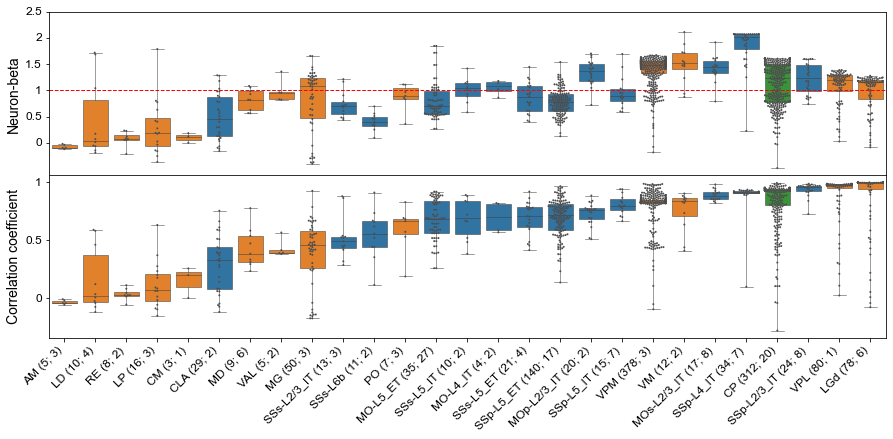

In [38]:
fig, ax = plt.subplots(2,1, figsize=(15,6), gridspec_kw={'hspace':0.0})
cgroup_list_sorted = beta.groupby('group')['corr'].median().sort_values().index.tolist()
region_cmap = [structure_cmap[group_meta.loc[i, 'Structure']] for i in cgroup_list_sorted]
ylab_dict = {'beta':'Neuron-beta', 'corr':'Correlation coefficient'}

for i,vtype in enumerate(['beta', 'corr']):
    cax = ax[i]
    sns.boxplot(x='group', 
                y=vtype, 
                order=cgroup_list_sorted,
    #             hue='group',
                palette=region_cmap,
                data=beta,
                ax=cax,
                whis=[0,100],  # don't show outliers
                linewidth=0.5,
    #             legend=False
               )
    sns.swarmplot(x="group", y=vtype, 
                  order=cgroup_list_sorted,
                  data=beta,
                  size=2, color=".3", linewidth=0,ax=cax)
    if vtype=='beta':
        cax.hlines(y=1, xmin=cax.get_xlim()[0], xmax=cax.get_xlim()[1], linestyles='dashed', color='red', linewidth=1)

    if i==0:
        cax.set_xticks([])
    else:
        xticklabels = []
        for i in cgroup_list_sorted:
            cmatches = matches[matches['reassigned primary-layer']==i].copy()
            slist = cmatches[cmatches['experiment-type']=='single cell'].index.tolist()
            mlist = cmatches[cmatches['experiment-type']=='mesoscale'].index.tolist()
            if i.endswith('-'):
                i = '-'.join(i.split('-')[:-1])
            i = i.replace('_PT', '_ET')
            i = '%s (%d; %d)' % (i, len(slist), len(mlist))
            xticklabels.append(i)
        cax.set_xticklabels(xticklabels, fontdict={'ha':'right', 'va':'top', 'rotation':45, 'size':12})
    cax.set_xlabel('')
    cax.set_ylabel(ylab_dict[vtype], fontdict={'size':14})

ax[0].set_yticks([0,0.5,1,1.5,2,2.5])
ax[0].set_yticklabels([0,0.5,1,1.5,2,2.5], fontdict={'ha':'right', 'va':'center', 'size':12})
ax[1].set_yticks([0,0.5,1])
ax[1].set_yticklabels([0,0.5,1], fontdict={'ha':'right', 'va':'center', 'size':12})

fig.savefig('../Figure/beta_and_corr_v2.pdf', bbox_inches='tight')

In [184]:
print(beta.groupby('group')['corr'].median().sort_values())
print(beta.groupby('group')['corr'].median().median())

group
AM            -0.041608
LD             0.021817
RE             0.027543
LP             0.074739
CM             0.199418
CLA            0.330448
MD             0.383740
VAL            0.392529
MG             0.456106
SSs-L2/3_IT    0.490445
SSs-L6b        0.556192
PO             0.663651
MO-L5_ET       0.685233
SSs-L5_IT      0.693530
MO-L4_IT       0.700796
SSs-L5_ET      0.706399
SSp-L5_ET      0.713277
MOp-L2/3_IT    0.762058
SSp-L5_IT      0.795578
VPM            0.826236
VM             0.833260
MOs-L2/3_IT    0.878740
SSp-L4_IT      0.908509
CP             0.929525
SSp-L2/3_IT    0.959994
VPL            0.973606
LGd            0.995666
Name: corr, dtype: float64
0.693530099816106


In [45]:
# fig, ax = plt.subplots(2,1, figsize=(15,6), gridspec_kw={'hspace':0.0})
# cgroup_list_sorted = beta.groupby('group')['beta'].median().sort_values().index.tolist()
# region_cmap = [structure_cmap[group_meta.loc[i, 'Structure']] for i in cgroup_list_sorted]
# ylab_dict = {'beta':'Neuron-beta', 'corr':'Correlation coefficient'}

# for i,vtype in enumerate(['beta', 'corr']):
#     cax = ax[i]
#     sns.boxplot(x='group', 
#                 y=vtype, 
#                 order=cgroup_list_sorted,
#     #             hue='group',
#                 palette=region_cmap,
#                 data=beta,
#                 ax=cax,
#                 whis=[0,100],  # don't show outliers
#                 linewidth=0.5,
#     #             legend=False
#                )
#     sns.swarmplot(x="group", y=vtype, 
#                   order=cgroup_list_sorted,
#                   data=beta,
#                   size=2, color=".3", linewidth=0,ax=cax)
#     if vtype=='beta':
#         cax.hlines(y=1, xmin=cax.get_xlim()[0], xmax=cax.get_xlim()[1], linestyles='dashed', color='red', linewidth=1)

#     if i==0:
#         cax.set_xticks([])
#     else:
#         xticklabels = []
#         for i in cgroup_list_sorted:
#             cmatches = matches[matches['reassigned primary-layer']==i].copy()
#             slist = cmatches[cmatches['experiment-type']=='single cell'].index.tolist()
#             mlist = cmatches[cmatches['experiment-type']=='mesoscale'].index.tolist()
#             if i.endswith('-'):
#                 i = '-'.join(i.split('-')[:-1])
#             i = i.replace('_PT', '_ET')
#             i = '%s (%d; %d)' % (i, len(slist), len(mlist))
#             xticklabels.append(i)
#         cax.set_xticklabels(xticklabels, fontdict={'ha':'right', 'va':'top', 'rotation':45, 'size':12})
#     cax.set_xlabel('')
#     cax.set_ylabel(ylab_dict[vtype], fontdict={'size':14})

# ax[0].set_yticks([0,0.5,1,1.5,2,2.5])
# ax[0].set_yticklabels([0,0.5,1,1.5,2,2.5], fontdict={'ha':'right', 'va':'center', 'size':12})
# ax[1].set_yticks([0,0.5,1])
# ax[1].set_yticklabels([0,0.5,1], fontdict={'ha':'right', 'va':'center', 'size':12})

# fig.savefig('../Figure/beta.pdf', bbox_inches='tight')

## Regression analysis

In [76]:
def get_group_df_regression(group_name, region_list=None, mlist=None):
    cmatches = matches[matches['reassigned primary-layer']==group_name].copy()
    slist = cmatches[cmatches['experiment-type']=='single cell'].index.tolist()
    if mlist is None:
        mlist = cmatches[cmatches['experiment-type']=='mesoscale'].index.tolist()
    
    if region_list is None:
        _, region_list = get_region_list(group_name)
    
    # Get dataframe
    sdf = singlecell_axon_matrix.loc[slist, region_list].copy()
    sdf = sdf / np.array(sdf.sum(axis=1)).reshape(-1,1) * 100
    
    mdf = mesoscale_projection_volumes.loc[mlist, region_list].copy()
    mdf = mdf.mean(axis=0) * 100
    
    return sdf, mdf

def get_group_mean(group_name, region_list=None):
    cmatches = matches[matches['reassigned primary-layer']==group_name].copy()
    slist = cmatches[cmatches['experiment-type']=='single cell'].index.tolist()
    mlist = cmatches[cmatches['experiment-type']=='mesoscale'].index.tolist()
    
    if region_list is None:
        _, region_list = get_region_list(group_name)
    
    # Get dataframe
    sdf = singlecell_axon_matrix.loc[slist, region_list].copy()
    sdf = sdf / np.array(sdf.sum(axis=1)).reshape(-1,1) * 100
    sdf.dropna(axis=0, inplace=True)
    sdf = sdf.mean(axis=0)
    
    mdf = mesoscale_projection_volumes.loc[mlist, region_list].copy()
    mdf = mdf.mean(axis=0) * 100
    
    return sdf, mdf        

In [95]:
def my_r2(y_true, y_pred):
    SS_res = np.sum(np.square(y_true - y_pred))
    SS_tot = np.sum(np.square(y_true - np.mean(y_true)))
    r2 = 1 - SS_res/SS_tot
    return r2

def my_lasso(cgroup, alpha=0.1, mlist=None, min_w=0):
    sdf, mdf = get_group_df_regression(cgroup)
    sdf.dropna(axis=0, inplace=True)
    clf = linear_model.Lasso(alpha=alpha, fit_intercept=False, positive=True, max_iter=10000)
    X = np.array(sdf.transpose())
    y = np.array(mdf)
    clf.fit(X, y)
    w_old = clf.coef_.copy()
    s_old = clf.score(X, y)
    w_new = clf.coef_
    w_new[w_new<=min_w] = 0
    s_new = clf.score(X, y)
    print('%s:\t%d/%d/%d\t%.2f\t%.2f' % (cgroup, np.sum(w_new>0), np.sum(w_old>0), len(sdf), 
                                         s_old, s_new
                                        ))
    return w_new, np.dot(X, w_new), y, s_new, sdf[w_new>0].index.tolist()


def my_corr(cgroup, w):
    sdf, _ = get_group_df_regression(cgroup)
    sdf.dropna(axis=0, inplace=True)
    in_list = [sdf.index.tolist()[i] for i,j in enumerate(w) if j>0]
    out_list = [sdf.index.tolist()[i] for i,j in enumerate(w) if j==0]
    if len(in_list)<2:
        cc1 = np.array([])
    else:
        id1 = np.triu_indices(len(in_list), 1)
        cc1 = np.corrcoef(sdf.loc[in_list])[id1[0], id1[1]]
    if len(out_list)<2:
        cc2 = np.array([])
    else:
        id2 = np.triu_indices(len(out_list), 1)
        cc2 = np.corrcoef(sdf.loc[out_list])[id2[0], id2[1]]
    res = pd.DataFrame({'Corr':list(cc1)+list(cc2),
                        'Group':[cgroup]*(len(cc1)+len(cc2)),
                        'Fitting_used':['Fitting']*len(cc1)+['Non-Fitting']*len(cc2)
                       })
    return res

# cgroup = 'CP-'
# # w, y_fit, y, coefficient_of_determination, slist = my_lasso(cgroup)
# my_corr(cgroup, w)

## Compare single cell average with mesoscale

In [49]:
import os

swc_path = '/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/swc/Mapped_Feb2021/3_flip_s25_resample/'
swc_list = [swc_path+i for i in os.listdir(swc_path) if i.endswith('swc')]
name_list = [i.split('.')[0] for i in os.listdir(swc_path) if i.endswith('swc')]
df_swc = pd.DataFrame({'swc_file':swc_list}, index=name_list)

ccf_image = '/Users/pengxie/Documents/Research/CCF/template/average_template_25.nrrd.UNIT8.v3draw'
def get_ano(cgroup):
    name_list = fit_meta.loc[cgroup, 'Cell_list']
    cgroup = cgroup.replace('/', '-')
    f = open('./ano/'+cgroup+'.ano', 'w')
    f.write('RAWIMG='+ccf_image+'\n')
    for i in name_list:
        f.write('SWCFILE='+df_swc.loc[i, 'swc_file']+'\n')
    f.close()
    return



In [52]:
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import linear_model
from scipy import stats
import numpy as np
import math
import os
import scipy.optimize as opt
import pickle


In [50]:
y1_true = np.array([])
y1_pred = np.array([])
color1 = []
for i in cgroup_list:
    sdf, mdf = get_group_mean(i)
    y1_true = np.concatenate([y1_true, np.array(mdf)])
    y1_pred = np.concatenate([y1_pred, np.array(sdf)])
    color1 = color1 + [structure_cmap[group_meta.loc[i, 'Structure']]]*len(mdf)

In [96]:
fit_meta = pd.DataFrame(index=cgroup_list, columns=['N_single', 
                                                    'N_region',
                                                    'Total_single', 
                                                    'Ratio_single',                                                     
                                                    'Coefficient_of_determination',
                                                    'Celltype',
                                                    'Cell_list'
                                                   ])
df_corr = pd.DataFrame(columns=['Corr', 'Group', 'Fitting_used'])

min_w = 0.01
y_true = np.array([])
y_pred = np.array([])
color2 = []
for i in cgroup_list[:]:
    w, y_fit, y, coefficient_of_determination, slist = my_lasso(i, alpha=0.1, min_w=min_w)
    
    df_corr = pd.concat([df_corr, my_corr(i, w)], axis=0)
    if coefficient_of_determination > 0.05:
        y_true = np.concatenate([y_true, y])
        y_pred = np.concatenate([y_pred, y_fit])
        color2 = color2 + [structure_cmap[group_meta.loc[i, 'Structure']]]*len(y)
    fit_meta.loc[i] = [len(slist), len(y), len(w), len(slist)/len(w), coefficient_of_determination, i, slist]
    get_ano(i)


MOp-L2/3_IT:	7/8/20	0.97	0.97
MOs-L2/3_IT:	4/4/17	0.97	0.97
MO-L4_IT:	2/2/4	0.75	0.75
MO-L5_IT:	2/2/8	0.69	0.69
MO-L5_ET:	16/17/35	1.00	1.00
SSp-L2/3_IT:	13/15/24	1.00	1.00
SSp-L4_IT:	5/6/34	0.55	0.55
SSp-L5_IT:	8/8/15	0.87	0.87
SSp-L5_ET:	16/22/140	0.99	0.99
SSs-L2/3_IT:	5/5/13	0.48	0.48
SSs-L5_IT:	4/4/10	0.88	0.88
SSs-L5_ET:	8/9/21	0.88	0.88
SSs-L6b:	6/6/11	0.84	0.84
CLA:	7/7/29	0.74	0.74
VPL:	7/8/80	0.62	0.62
VPM:	10/10/378	1.00	1.00
LGd:	8/11/78	1.00	1.00
MG:	5/6/50	0.87	0.87
VAL:	1/1/5	0.19	0.19
PO:	3/3/7	0.20	0.20
VM:	4/4/12	0.86	0.86
LP:	7/7/16	0.66	0.66
AM:	1/2/5	-0.28	-0.28
LD:	4/4/10	0.18	0.18
RE:	2/4/8	-0.15	-0.16
CM:	3/3/3	0.07	0.07
MD:	4/4/9	0.66	0.66
CP:	14/60/312	1.00	0.99


In [97]:
pickle.dump([fit_meta], open('./single_meso_fit_v2.pickle', 'wb'))

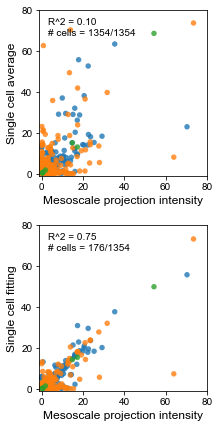

In [98]:
fig, ax = plt.subplots(2,1, figsize=(3,7), gridspec_kw={'hspace':.3})
# 1. single cell average v.s mesoscale
cax = ax[0]
cax.scatter(y1_true, y1_pred, 
            s=30,
            c=color1,
            linewidths=0,
            alpha=0.8)
cax.set_xlabel('Mesoscale projection intensity', fontdict={'fontsize':12})
cax.set_xlim((-1,80))
cax.set_ylim((-1,80))
cax.set_xticks([0,20,40,60,80])
cax.set_xticklabels([0,20,40,60,80])
cax.set_yticks([0,20,40,60,80])
cax.set_yticklabels([0,20,40,60,80])
_ = cax.set_ylabel('Single cell average', fontdict={'fontsize':12})
_ = cax.text(cax.get_xlim()[0]*0.95+cax.get_xlim()[1]*0.05,
            cax.get_ylim()[0]*0.15+cax.get_ylim()[1]*0.85,
            'R^2 = %.2f\n# cells = %d/%d' % (my_r2(y1_true, y1_pred), 
                                        np.sum(fit_meta['Total_single']),
                                        np.sum(fit_meta['Total_single'])
                                       )
       )

# 2. single cell Lasso v.s mesoscale
cax = ax[1]
cax.scatter(y_true, y_pred, 
            s=30, 
            alpha=0.8, 
            linewidths=0,
            c=color2)
cax.set_xlabel('Mesoscale projection intensity', fontdict={'fontsize':12})
cax.set_xlim((-1,80))
cax.set_ylim((-1,80))
cax.set_xticks([0,20,40,60,80])
cax.set_xticklabels([0,20,40,60,80])
cax.set_yticks([0,20,40,60,80])
cax.set_yticklabels([0,20,40,60,80])
_ = cax.set_ylabel('Single cell fitting', fontdict={'fontsize':12})
_ = cax.text(cax.get_xlim()[0]*0.95+cax.get_xlim()[1]*0.05,
            cax.get_ylim()[0]*0.15+cax.get_ylim()[1]*0.85,
            'R^2 = %.2f\n# cells = %d/%d' % (my_r2(y_true, y_pred), 
                                        np.sum(fit_meta['N_single']),
                                        np.sum(fit_meta['Total_single'])
                                       )
            )
fig.savefig('../Figure/single_vs_mesoscale_fitting_scatter_v2.pdf', bbox_inches='tight')

In [99]:
norm_factor = 1/15
pdf1 = fit_meta[['N_single', 'Celltype']].rename(columns={'N_single':'value'}) 
pdf1['value'] = pdf1['value'] * norm_factor
pdf1['type'] = '# of single cell'
pdf2 = fit_meta[['Coefficient_of_determination', 'Celltype']].rename(columns={'Coefficient_of_determination':'value'})
pdf2['type'] = 'Coefficient_of_determination'
pdf = pd.concat([pdf1, pdf2], axis=0)

In [101]:
pdf

,value,Celltype,type
MOp-L2/3_IT,0.466667,MOp-L2/3_IT,# of single cell
MOs-L2/3_IT,0.266667,MOs-L2/3_IT,# of single cell
MO-L4_IT,0.133333,MO-L4_IT,# of single cell
MO-L5_IT,0.133333,MO-L5_IT,# of single cell
MO-L5_ET,1.06667,MO-L5_ET,# of single cell
SSp-L2/3_IT,0.866667,SSp-L2/3_IT,# of single cell
SSp-L4_IT,0.333333,SSp-L4_IT,# of single cell
SSp-L5_IT,0.533333,SSp-L5_IT,# of single cell
SSp-L5_ET,1.06667,SSp-L5_ET,# of single cell
SSs-L2/3_IT,0.333333,SSs-L2/3_IT,# of single cell


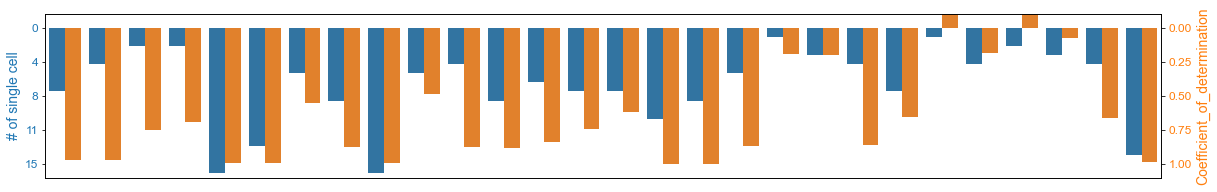

In [102]:
norm_factor = 1/15
pdf1 = fit_meta[['N_single', 'Celltype']].rename(columns={'N_single':'value'}) 
pdf1['value'] = pdf1['value'] * norm_factor
pdf1['type'] = '# of single cell'
pdf2 = fit_meta[['Coefficient_of_determination', 'Celltype']].rename(columns={'Coefficient_of_determination':'value'})
pdf2['type'] = 'Coefficient_of_determination'
pdf = pd.concat([pdf1, pdf2], axis=0)

palette = sns.palettes.color_palette('tab10',2)

fig, ax = plt.subplots(1,1, figsize=(20,3))
sns.barplot(x='Celltype', y='value', 
            hue='type', hue_order=['# of single cell', 'Coefficient_of_determination'],
            palette=palette, 
            data=pdf, ax=ax)
color = palette[0]
ax.set_xlabel('')
ax.set_ylabel('# of single cell', color=color, fontdict={'fontsize':14})
ax.tick_params(axis='y', labelcolor=color, labelsize=12)
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticklabels(list(np.round(np.array([0,0.25,0.5,0.75,1])/norm_factor,0).astype(int)))
ax.get_legend().remove()
ax.set_xticks([])
_ = ax.invert_yaxis()

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color=palette[1]
ax2.set_ylabel('Coefficient_of_determination', color=color, fontdict={'fontsize':14})  # we already handled the x-label with ax1

ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
_ = ax2.invert_yaxis()

ax.set_ylim((1.1,-0.1))
ax2.set_ylim((1.1,-0.1))

fig.savefig('../Figure/single_vs_mesoscale_fitting_v2.pdf', bbox_inches='tight')